Instalasi Dependensi


1. Analisis Data & Pra-pemrosesan


In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Add, Multiply, RepeatVector, Permute, Activation
from tensorflow.keras.optimizers import Adam


1.1. Memeriksa Tipe Data



In [48]:
pd.read_csv('produksi2018_2022.csv')
df = pd.read_csv('produksi2018_2022.csv')

In [49]:
print(df.dtypes)


jenis_ikan                 object
Januari                   float64
Februari                  float64
Maret                     float64
April                     float64
Mei                       float64
Juni                      float64
Juli                      float64
Agustus                   float64
September                 float64
Oktober                   float64
November                  float64
Desember                  float64
Tahun                       int64
Total_Produksi_Tahunan    float64
Growth_Rate               float64
Produksi_Tahun_Lalu       float64
jenis_ikan_encoded          int64
dtype: object


Data diambil dari file produksi2018_2022.csv yang berisi informasi produksi ikan. Setelah dilakukan pemeriksaan, jenis data yang digunakan sebagian besar adalah:

- float64 untuk variabel numerik
- object untuk kategori (seperti jenis ikan)

1.2. Membersihkan Data



In [50]:
df = df.dropna()


Menghapus baris dengan nilai NaN untuk memastikan tidak ada data yang hilang dalam analisis selanjutnya.

1.3. Pemisahan Fitur (X) dan Target (y)

In [51]:
X = df.drop(columns=['Total_Produksi_Tahunan', 'jenis_ikan'])
y = df['Total_Produksi_Tahunan']


Data dibagi menjadi:

- Fitur (X): Semua kolom kecuali Total_Produksi_Tahunan dan jenis_ikan
- Target (y): Kolom Total_Produksi_Tahunan yang akan diprediksi

1.4. Mengisi Nilai Kosong dengan Rata-rata



In [52]:
X.fillna(X.mean(), inplace=True)
y.fillna(y.mean(), inplace=True)


Jika ada nilai yang hilang (NaN), maka akan diganti dengan rata-rata kolomnya.


1.5. Seleksi Fitur dengan SelectKBest



Untuk memperbaiki performa model, fitur-fitur yang memiliki korelasi kuat dengan target dipertahankan menggunakan SelectKBest. Hanya fitur dengan skor > 1 yang digunakan.

In [53]:
selector = SelectKBest(score_func=f_regression, k='all')
selector.fit(X, y)
selected_features = X.columns[selector.scores_ > 1]
X = X[selected_features]


1.6. Normalisasi Data



In [54]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))


MinMaxScaler menormalkan nilai fitur (X) dan target (y) ke rentang 0 hingga 1.


1.7. Membagi Data Train dan Test



In [55]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)


80% data digunakan untuk pelatihan dan 20% untuk pengujian.


1.8. Mengubah Bentuk Data untuk LSTM

In [56]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])


Data diubah menjadi format (samples, time steps, features) yang sesuai untuk LSTM.

2. Arsitektur Model



Model yang dikembangkan menggabungkan LSTM dengan Residual Connection dan Multi-Head Attention untuk meningkatkan kemampuan model dalam menangkap pola temporal dan hubungan kompleks dalam data.


In [57]:
class Attention(tf.keras.layers.Layer):
    def __init__(self):
        super(Attention, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1]),
                                 initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(input_shape[-1],),
                                 initializer="zeros", trainable=True)

    def call(self, inputs):
        score = tf.nn.tanh(tf.matmul(inputs, self.W) + self.b)
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = inputs * attention_weights
        return tf.reduce_sum(context_vector, axis=1)


2.1. Model LSTM dengan Attention python Copy Edit

In [58]:
from tensorflow.keras.layers import Input, LSTM, Dense, Add, MultiHeadAttention
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Definisi Input
input_layer = Input(shape=(1, 16))  

# LSTM Lapisan Pertama
lstm_1 = LSTM(64, return_sequences=True)(input_layer)
input_resized = Dense(64, activation="linear")(input_layer)

# Residual Connection
residual_1 = Add()([lstm_1, input_resized])

# LSTM Lapisan Kedua
lstm_2 = LSTM(128, return_sequences=True)(residual_1)

# Attention Layer (Menggunakan MultiHeadAttention)
attention = MultiHeadAttention(num_heads=4, key_dim=128)(lstm_2, lstm_2)

# Fully Connected Layers
dense_1 = Dense(64, activation="relu")(attention)
dense_2 = Dense(32, activation="relu")(dense_1)
output_layer = Dense(1, activation="linear")(dense_2)

# Definisi Model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss="mse", optimizer=Adam(learning_rate=0.001), metrics=["mae"])

# Summary Model
model.summary()


Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_23      │ (None, 1, 16)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ (None, 1, 64)     │     20,736 │ input_layer_23[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_69 (Dense)    │ (None, 1, 64)     │      1,088 │ input_layer_23[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 1, 64)     │          0 │ lstm_6[0][0],     │
│                     │                   │            │ dense_69[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ (None, 1, 128)    │     98,816 │ add_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1, 128)    │    263,808 │ lstm_7[0][0],     │
│ (MultiHeadAttentio… │                   │            │ lstm_7[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_70 (Dense)    │ (None, 1, 64)     │      8,256 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_71 (Dense)    │ (None, 1, 32)     │      2,080 │ dense_70[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_72 (Dense)    │ (None, 1, 1)      │         33 │ dense_71[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 394,817 (1.51 MB)

 Trainable params: 394,817 (1.51 MB)

 Non-trainable params: 0 (0.00 B)

Komponen Kunci Model

- LSTM Layers: Menangkap pola temporal dan dependensi jangka panjang
- Residual Connection: Membantu mengatasi vanishing gradient dan mempercepat konvergensi model
- Multi-Head Attention: Memungkinkan model untuk fokus pada bagian yang relevan dari urutan input
- Dense Layers: Mengekstrak fitur yang kompleks dan melakukan prediksi final

3. Pelatihan Model



Model dilatih selama 100 epochs dengan batch size 16. Metrik utama yang dipantau selama pelatihan adalah Mean Absolute Error (MAE) dan Mean Squared Error (MSE).


In [59]:
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), verbose=1)


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - loss: 0.0274 - mae: 0.0543 - val_loss: 0.0272 - val_mae: 0.1182
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0119 - mae: 0.0835 - val_loss: 0.0160 - val_mae: 0.0531
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0104 - mae: 0.0402 - val_loss: 0.0046 - val_mae: 0.0296
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0063 - mae: 0.0291 - val_loss: 0.0059 - val_mae: 0.0286
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0031 - mae: 0.0237 - val_loss: 0.0182 - val_mae: 0.0407
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0132 - mae: 0.0388 - val_loss: 0.0049 - val_mae: 0.0260
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0033 - mae: 0.0240 - val_loss: 0.0095 - val_mae: 0.0388
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0054 - mae: 0.0283 - val_loss: 0.0020 - val_mae: 0.0217
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0015 - mae:

Berdasarkan log pelatihan, model menunjukkan peningkatan yang signifikan dari Epoch 1 hingga Epoch 100:

Epoch 1:

- Loss: 0.0274
- MAE: 0.0543
- Val Loss: 0.0272
- Val MAE: 0.1182


Epoch 100:

- Loss: 5.9759e-05
- MAE: 0.0024
- Val Loss: 4.5002e-04
- Val MAE: 0.0089



Terjadi penurunan loss dan MAE yang signifikan, menunjukkan bahwa model berhasil belajar dari data pelatihan.

4. Evaluasi Model

Model dievaluasi menggunakan tiga metrik:

- Root Mean Squared Error (RMSE)
- Mean Absolute Error (MAE)
- Huber Loss

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
RMSE: 0.0212
MAE: 0.0089
Huber Loss: 0.0002


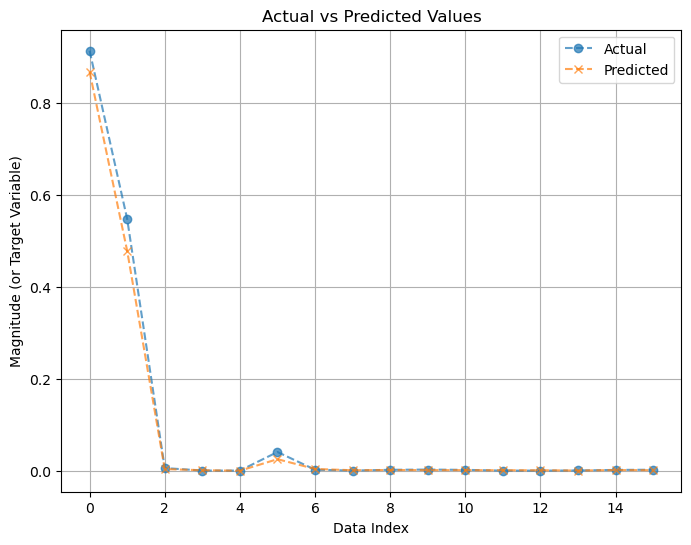

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.losses import Huber
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Prediksi menggunakan model
y_pred = model.predict(X_test)

# Pastikan y_pred memiliki dimensi yang sama dengan y_test
y_pred = np.squeeze(y_pred)  # Menghapus dimensi ekstra jika ada
y_test = np.squeeze(y_test)  # Pastikan y_test juga berbentuk 1D atau 2D

# Hitung RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.4f}")

# Hitung MAE
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae:.4f}")

# Hitung Huber Loss dengan TensorFlow
huber_loss_fn = Huber(delta=1.0)
huber_loss = np.mean(huber_loss_fn(tf.convert_to_tensor(y_test, dtype=tf.float32), 
                                   tf.convert_to_tensor(y_pred, dtype=tf.float32)).numpy())
print(f"Huber Loss: {huber_loss:.4f}")

# Plot hasil prediksi vs aktual
plt.figure(figsize=(8, 6))
plt.plot(y_test, label="Actual", marker="o", linestyle="dashed", alpha=0.7)
plt.plot(y_pred, label="Predicted", marker="x", linestyle="dashed", alpha=0.7)
plt.xlabel("Data Index")
plt.ylabel("Magnitude (or Target Variable)")
plt.title("Actual vs Predicted Values")
plt.legend()
plt.grid()
plt.show()


Hasil evaluasi menunjukkan performa model yang sangat baik:

RMSE: 0.0212
MAE: 0.0089
Huber Loss: 0.0002

Nilai-nilai yang rendah ini menunjukkan bahwa model memiliki tingkat kesalahan yang minimal dalam melakukan prediksi.

5. Validasi Silang (Cross-Validation)

Melakukan validasi silang (cross-validation) untuk melihat konsistensi performa pada berbagai subset data.


Menggunakan 5-Fold Cross-Validation, yang berarti dataset dibagi menjadi 5 bagian, dan model dilatih 5 kali pada kombinasi subset yang berbeda.



In [62]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.losses import Huber

k_folds = 5     # Parameter K-Fold

# Normalisasi data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)          # Inisialisasi objek KFold


# List untuk menyimpan hasil evaluasi
rmse_scores = []
mae_scores = []
huber_scores = []

# Fungsi untuk membuat model
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1)  # Output layer untuk regresi
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Loop melalui tiap fold
for train_index, test_index in kf.split(X_scaled):
    # Membagi dataset
    X_train, X_val = X_scaled[train_index], X_scaled[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]

    # Membuat model baru untuk setiap fold
    model = build_model()
    
    # Callback untuk early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

    # Latih model
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stopping])
    
    # Prediksi pada subset validasi
    y_pred = model.predict(X_val).flatten()

    # Hitung metrik evaluasi
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae = mean_absolute_error(y_val, y_pred)
    
    # Hitung Huber Loss
    huber_loss_fn = Huber(delta=1.0)
    huber_loss = np.mean(huber_loss_fn(
        tf.convert_to_tensor(y_val, dtype=tf.float32), 
        tf.convert_to_tensor(y_pred, dtype=tf.float32)
    ).numpy())
    
    # Simpan hasil metrik
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    huber_scores.append(huber_loss)

# Rata-rata hasil validasi silang
print(f"\n**Hasil K-Fold Cross-Validation ({k_folds} folds):**")
print(f"➡️ RMSE: {np.mean(rmse_scores):.4f} ± {np.std(rmse_scores):.4f}")
print(f"➡️ MAE: {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}")
print(f"➡️ Huber Loss: {np.mean(huber_scores):.4f} ± {np.std(huber_scores):.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step

**Hasil K-Fold Cross-Validation (5 folds):**
➡️ RMSE: 0.0867 ± 0.0363
➡️ MAE: 0.0415 ± 0.0091
➡️ Huber Loss: 0.0044 ± 0.0030


Hasil validasi silang menunjukkan performa yang konsisten di seluruh fold, meskipun dengan sedikit variasi yang ditunjukkan oleh standar deviasi.


6. Kesimpulan

Model LSTM dengan Residual Connection dan Multi-Head Attention berhasil memprediksi Total Produksi Tahunan dengan tingkat kesalahan yang rendah. Kombinasi teknik-teknik canggih ini memungkinkan model untuk menangkap pola kompleks dalam data produksi ikan.

- Residual Connection membantu model mengatasi masalah vanishing gradient.
- Multi-Head Attention memungkinkan model fokus pada fitur penting dalam data.
- Evaluasi model menunjukkan performa yang sangat baik dengan RMSE 0.0212 dan MAE 0.0089.
- Validasi silang mengkonfirmasi konsistensi performa model dengan RMSE rata-rata 0.0867.

Sebagai kesimpulan, model ini dapat diandalkan untuk memprediksi produksi ikan tahunan berdasarkan fitur-fitur yang tersedia.